In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import math

Instructions for updating:
non-resource variables are not supported in the long term


C:\Users\joska\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig



def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [4]:

def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


In [5]:

X = tf.placeholder(tf.float32, shape=[None, 784])

D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


Z = tf.placeholder(tf.float32, shape=[None, 100])

G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [6]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# # Original losses:
# # -------------------
D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))

In [7]:
# Alternative losses:
# # -------------------
# D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
# D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
# D_loss = D_loss_real + D_loss_fake
# G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

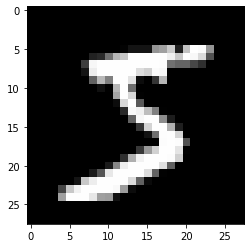

In [8]:
from datasets import MNISTDataset

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

plt.imshow(train_images[0], cmap="Greys_r")

data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

                    
for it in range(5000):
    X_mb,_ = data.next_batch()
    if X_mb.shape == (96,784):
        print(X_mb.shape)   

In [16]:

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

mb_size = 128
Z_dim = 100
n_iterations = 100000
path = "out_org_100k/"

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists(path):
    os.makedirs(path)

i = 0

for it in range(n_iterations+1):
    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})

        fig = plot(samples)
        plt.savefig('out_org_100k/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, _ = data.next_batch()


    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if math.isnan(D_loss_curr):
        print("oh no loss became nan at iteration",it) 
        break

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 0
D loss: 1.406
G_loss: 2.413

Iter: 1000
D loss: 0.003744
G_loss: 8.043

Iter: 2000
D loss: 0.02109
G_loss: 5.85

Iter: 3000
D loss: 0.1132
G_loss: 5.521

Iter: 4000
D loss: 0.1185
G_loss: 6.186

Iter: 5000
D loss: 0.1364
G_loss: 6.309

Iter: 6000
D loss: 0.3334
G_loss: 4.176

Iter: 7000
D loss: 0.5766
G_loss: 3.918

Iter: 8000
D loss: 0.4849
G_loss: 3.107

Iter: 9000
D loss: 0.4778
G_loss: 3.484

Iter: 10000
D loss: 0.4821
G_loss: 3.151

Iter: 11000
D loss: 0.5926
G_loss: 2.409

Iter: 12000
D loss: 0.5244
G_loss: 2.399

Iter: 13000
D loss: 0.6512
G_loss: 2.178

Iter: 14000
D loss: 0.7072
G_loss: 2.345

Iter: 15000
D loss: 0.5892
G_loss: 2.432

Iter: 16000
D loss: 0.6346
G_loss: 2.314

Iter: 17000
D loss: 0.6487
G_loss: 2.415

Iter: 18000
D loss: 0.7754
G_loss: 2.461

Iter: 19000
D loss: 0.6769
G_loss: 2.238

Iter: 20000
D loss: 0.6545
G_loss: 2.035

Iter: 21000
D loss: 0.7158
G_loss: 2.034

Iter: 22000
D loss: 0.8126
G_loss: 1.931

Iter: 23000
D loss: 0.7853
G_loss: 1.986

